Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/data/'

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [26]:
def wrangle(fm_path, tv_path=None):
  # Import CSV files
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['construction_year', 'date_recorded']), 
                  pd.read_csv(tv_path)).set_index('id')

    # Add new binary target
    df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
    
    # Drop old target
    df.drop(columns='status_group', inplace=True)
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08],
                     parse_dates=['construction_year', 'date_recorded']).set_index('id')

  # Feature engineering (Credit: Mena and Keila)
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'].dt.year

  # Drop constant and repeated columns
  df.drop(columns=['recorded_by', 'extraction_type_group', 'quantity_group',
                   'construction_year', 'date_recorded'], 
          inplace=True)
  
  # Drop columns with high % of NaN values
  df.dropna(axis=1, thresh=len(df)*.6, inplace=True)

  return df

df = wrangle(fm_path=DATA_PATH+'waterpumps/train_features.csv',
             tv_path=DATA_PATH+'waterpumps/train_labels.csv')

X_test = wrangle(fm_path=DATA_PATH+'waterpumps/test_features.csv')

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [9]:
# df['status_group'].value_counts()

functional                 32259
non functional             22823
functional needs repair     4317
Name: status_group, dtype: int64

`.str.replace()` (Nathan)

In [ ]:
# df['needs_repair'] = df['status_group'].replace(['functional','non functional','functional needs repair'],['0','1','1']).astype(int)

Logical operator (Jack)

In [10]:
# df['needs_repair'] = (df['status_group'] != 'functional').astype(int)

# II. Split Data

In [27]:
# Split TV / FM
target = 'needs_repair'
y = df[target]
X = df.drop(columns=target)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [28]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# Build Model

- `OrdinalEncoder`
- `SimpleImputer`
- `RandomForestClassifier`

In [29]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train, y_train);

# Interlude: Beware or Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**. 

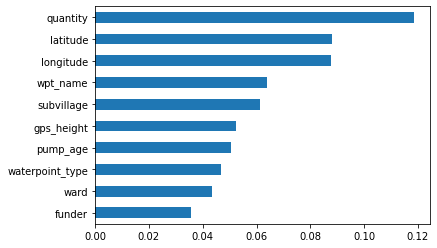

In [31]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh')

# Check Metrics

**Accuracy**

In [30]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9994528504387719
Validation Accuracy: 0.818939393939394


**Confusion Matrix**

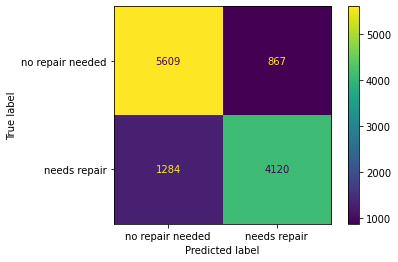

In [32]:
plot_confusion_matrix(
    model,
    X_val, # BE SURE TO USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['no repair needed', 'needs repair']
);

**Recall:** Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?
- "Catching them all"
- AKA sensitivity
- What proportion of true positives were labeled as positive by model?
- Side to side

In [33]:
4120 / (1284 + 4120)

0.7623982235381199

**Precision:** Of all the pumps that you predicted as needing repair, what proportion actually needed repair?
- What proportion of those labeled as positive are actually positive?
- Up and down

In [ ]:
4120 / (4120 + 867)

0.826147984760377

**Classification Report**

In [34]:
print(classification_report(y_val,
                            model.predict(X_val),
                            target_names=['no repair needed', 'needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.81      0.87      0.84      6476
    needs repair       0.83      0.76      0.79      5404

        accuracy                           0.82     11880
       macro avg       0.82      0.81      0.82     11880
    weighted avg       0.82      0.82      0.82     11880



In [35]:
model.predict_proba(X_val)

array([[0.  , 1.  ],
       [0.64, 0.36],
       [0.86, 0.14],
       ...,
       [0.9 , 0.1 ],
       [0.44, 0.56],
       [0.48, 0.52]])

In the array above, the first column is probability of getting 0, and the second column is probability of getting 1.

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [36]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [37]:
repair_prob = y_val.value_counts(normalize=True).min()
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', round(n_inspections * repair_prob))
print('Funds wasted:', round(n_inspections * (1-repair_prob) * 100))

Inspections conducted: 2000
Pumps repaired: 910
Funds wasted: 109024


Scenario 2: Using our model "out of the box"

In [38]:
# Put true values and predictions into DataFrame
data = {'y_val': y_val,
        'y_pred': model.predict(X_val)}
results = pd.DataFrame(data)

# Make sample with size of inspections, to see how much funds are wasted according to model
mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', round((n_inspections - sample['y_val'].sum()) * 100))

Inspections conducted: 2000
Pumps repaired: 1611
Funds wasted: 38900


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.9`) need repair.

In [40]:
data = {'y_val': y_val,
        'y_pred_proba': model.predict_proba(X_val)[:, 1]}
results = pd.DataFrame(data)

threshold = 0.85
mask = results['y_pred_proba'] > threshold
sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', round((n_inspections - sample['y_val'].sum()) * 100))

Inspections conducted: 2000
Pumps repaired: 1941
Funds wasted: 5900
